In [50]:
import sys
import os
from pathlib import Path

notebook_dir = os.path.dirname(os.path.abspath("__file__"))
sys.path.append(notebook_dir)


DATA_DIR_ENV = os.getenv("TAU2_DATA_DIR")

if DATA_DIR_ENV:
    data_dir = Path(DATA_DIR_ENV)
else:
    # Fallback to source directory (for development)
    repo_root = str(Path(notebook_dir).parent)
    data_dir = f"{repo_root}/data"


In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


In [52]:
%load_ext autoreload
%autoreload 2

# General Analysis
- Read the evaluation results
- Eval results are stored in a structure json file, and there is a shortcut utility to convert this to a dataframe.
- Keep only relevant columns 


In [ ]:
from tau2.data_model.simulation import Results

grok_airline_results = Results.load(
    Path(f"{data_dir}/simulations/grok_airline_all.json")
)

grok_airline_results_df = grok_airline_results.to_df()

print(grok_airline_results_df.shape)
print(grok_airline_results_df.columns)

(250, 27)
Index(['simulation_id', 'task_id', 'trial', 'seed', 'reward', 'agent_cost',
       'user_cost', 'termination_reason', 'duration', 'num_messages',
       'info_git_commit', 'info_seed', 'info_num_trials', 'info_max_steps',
       'info_max_errors', 'info_domain', 'info_user_implementation',
       'info_user_llm', 'info_user_llm_args', 'info_agent_implementation',
       'info_agent_llm', 'info_agent_llm_args', 'task_num_agent_actions',
       'task_num_user_actions', 'task_num_actions', 'task_num_env_assertions',
       'task_num_nl_assertions'],
      dtype='object')


In [28]:
grok_airline_results_df.head()

,simulation_id,task_id,trial,seed,reward,agent_cost,user_cost,termination_reason,duration,num_messages,...,info_user_llm,info_user_llm_args,info_agent_implementation,info_agent_llm,info_agent_llm_args,task_num_agent_actions,task_num_user_actions,task_num_actions,task_num_env_assertions,task_num_nl_assertions
0,f8fdc8d8-2d0a-409c-b41b-027a87ada931,0,0,626729,1.0,0.005671,0.000802,TerminationReason.USER_STOP,15.093967,10,...,xai/grok-4-fast-reasoning,{'temperature': 0.0},llm_agent,xai/grok-4-fast-reasoning,{'temperature': 0.0},0,0,0,0,1
1,c8986318-6fe4-4f73-a08e-8adac924fb3e,1,0,626729,1.0,0.015513,0.001152,TerminationReason.USER_STOP,22.895670,22,...,xai/grok-4-fast-reasoning,{'temperature': 0.0},llm_agent,xai/grok-4-fast-reasoning,{'temperature': 0.0},2,0,2,0,1
2,8859a58e-afc0-499e-93ef-327331533127,3,0,626729,1.0,0.009049,0.001607,TerminationReason.USER_STOP,22.764926,14,...,xai/grok-4-fast-reasoning,{'temperature': 0.0},llm_agent,xai/grok-4-fast-reasoning,{'temperature': 0.0},2,0,2,0,2
3,0b89b572-ee64-42ae-8556-fcc362602314,4,0,626729,1.0,0.018365,0.001883,TerminationReason.USER_STOP,31.408852,24,...,xai/grok-4-fast-reasoning,{'temperature': 0.0},llm_agent,xai/grok-4-fast-reasoning,{'temperature': 0.0},6,0,6,0,2
4,6571f0cf-9663-43b5-afdc-21392fd57b95,2,0,626729,1.0,0.021557,0.005920,TerminationReason.USER_STOP,65.517945,28,...,xai/grok-4-fast-reasoning,{'temperature': 0.0},llm_agent,xai/grok-4-fast-reasoning,{'temperature': 0.0},4,0,4,0,4


In [18]:
relevant_columns = [
    "task_id",
    "trial",
    "reward",
    "agent_cost",
    "user_cost",
    "duration",
    "num_messages",
    "task_num_agent_actions",
    # "task_num_user_actions", # Always 0 for airline
    # "task_num_actions", # Same as task_num_agent_actions since no user actions
]
filtered_airline_results = grok_airline_results_df[relevant_columns]
filtered_airline_results.head()

,task_id,trial,reward,agent_cost,user_cost,duration,num_messages,task_num_agent_actions
0,0,0,1.0,0.005671,0.000802,15.093967,10,0
1,1,0,1.0,0.015513,0.001152,22.895670,22,2
2,3,0,1.0,0.009049,0.001607,22.764926,14,2
3,4,0,1.0,0.018365,0.001883,31.408852,24,6
4,2,0,1.0,0.021557,0.005920,65.517945,28,4


In [93]:
filtered_airline_results = filtered_airline_results[filtered_airline_results["trial"] != 4]
print(filtered_airline_results.shape)

(200, 8)


<Axes: xlabel='trial', ylabel='reward'>

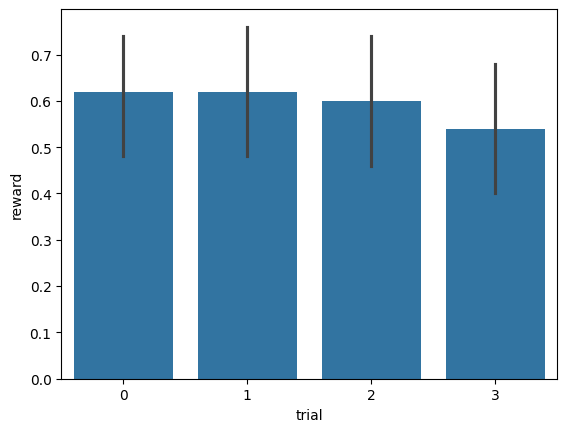

In [94]:
sns.barplot(x="trial", y="reward", data=filtered_airline_results)

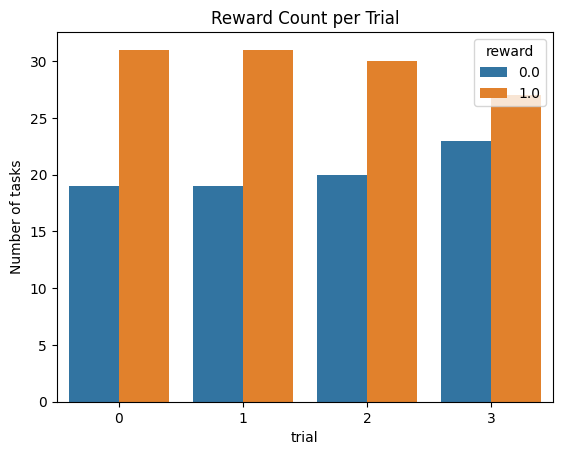

In [95]:
reward_grouped = filtered_airline_results.groupby(["trial", "reward"])["task_id"].count().reset_index()
reward_grouped = reward_grouped.rename(columns={"task_id": "count"})

sns.barplot(x="trial", y="count", hue="reward", data=reward_grouped)
plt.title("Reward Count per Trial")
plt.ylabel("Number of tasks")
plt.show()


In [96]:
def plot_col_dist_by_reward_vals(col_name: str, df: pd.DataFrame):
    plt.figure(figsize=(10,6))
    sns.histplot(
        df[df["reward"] == 0.0][col_name],
        label="reward=0",
        kde=True,
        stat="density",
        color="r",
        alpha=0.3,
        bins=15
    )

    sns.histplot(
        df[df["reward"] == 1.0][col_name],
        label="reward=1",
        kde=True,
        stat="density",
        color="g",
        alpha=0.3,
        bins=15
    )

    plt.legend()
    plt.xlabel(col_name)
    plt.ylabel("Density")
    plt.title(f"Distribution of {col_name} for reward=0 vs reward=1")
    plt.show()

Reward vs num_messages observation:
- When the reward is 1 or success, the distribution is concentrated on the lower range for `num_messages`. This peaks around 10-20 messages.
- Failed tasks have longer right tail with density extending from 25-50+ messages.

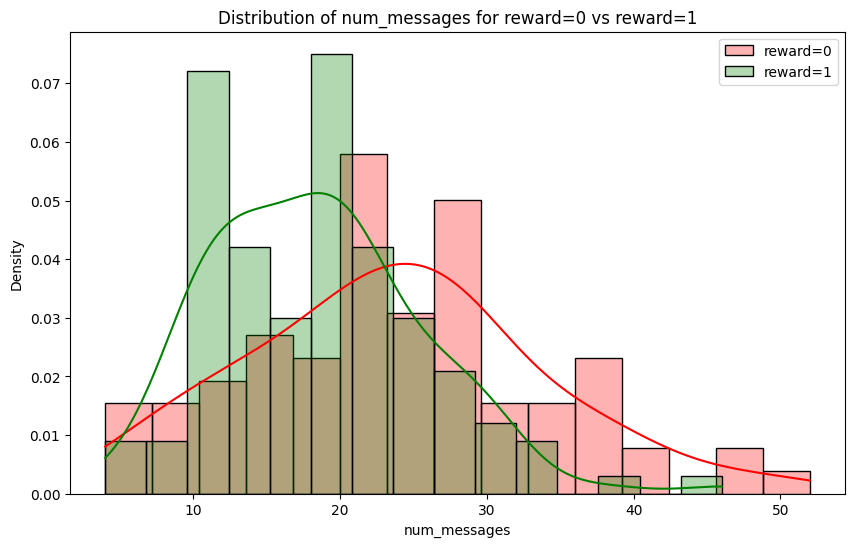

In [97]:
plot_col_dist_by_reward_vals("num_messages", filtered_airline_results)

Reward vs `task_num_agent_actions` observations: 
-  When the reward is 1 or success, observation is seen from the `task_num_agent_actions`. 
- Reward=1 is highly concentrated around 1-2 agent actions.
- The failure cases have high variances. Some tasks fail with few actions while others take up 20 actions

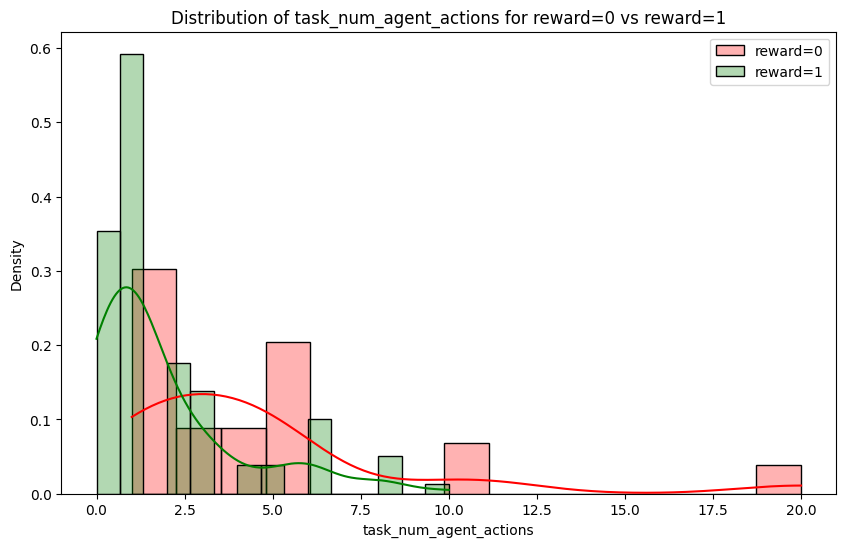

In [98]:
plot_col_dist_by_reward_vals("task_num_agent_actions", filtered_airline_results)

## Task category classification

In [ ]:
from airline_agent_eval_task_classifier import AirlineAgentEvalTaskClassifier

task_classifier = AirlineAgentEvalTaskClassifier(domain_dir=f"{data_dir}/tau2/domains/airline")
task_id_category = task_classifier.run(save_to_path=f"{data_dir}/experiments/domains/airline/task_category_mapping.json")

In [74]:
task_id_category_df = pd.DataFrame(
    [{"task_id": int(k), "category": str(v)} for k, v in task_id_category.items()]
)
task_id_category_df.head()

,task_id,category
0,0,Cancellation Policy Tricking
1,1,Cancellation Policy Tricking
2,2,Compensation/Complaints Tricking
3,3,Membership & Benefits
4,4,Compensation/Complaints Tricking


In [75]:
task_id_category_df["category"].value_counts()

category
Flight Modification                   11
Cancellation Policy Tricking           9
Complex Multi-Transaction              8
Flight Modification Tricking           6
Compensation/Complaints Tricking       4
Booking Creation                       3
Complex Multi-Transaction Tricking     3
Cancellation Policy                    2
Membership & Benefits                  1
Insurance Issues Tricking              1
Compensation/Complaints                1
Insurance Issues                       1
Name: count, dtype: int64

### Merge categories to tasks

In [114]:
filtered_airline_results["task_id"] = filtered_airline_results["task_id"].astype(int)

In [115]:

task_with_categories = filtered_airline_results.merge(
    task_id_category_df,
    on="task_id",
    how="inner"
)
task_with_categories.head()
# failed_task_trials_with_categories.sort_values(by="trial_count", ascending=False)

,task_id,trial,reward,agent_cost,user_cost,duration,num_messages,task_num_agent_actions,category
0,0,0,1.0,0.005671,0.000802,15.093967,10,0,Cancellation Policy Tricking
1,1,0,1.0,0.015513,0.001152,22.895670,22,2,Cancellation Policy Tricking
2,3,0,1.0,0.009049,0.001607,22.764926,14,2,Membership & Benefits
3,4,0,1.0,0.018365,0.001883,31.408852,24,6,Compensation/Complaints Tricking
4,2,0,1.0,0.021557,0.005920,65.517945,28,4,Compensation/Complaints Tricking


In [129]:
success_counts = task_with_categories[task_with_categories.reward == 1]["category"].value_counts()
total_counts = task_with_categories["category"].value_counts()
success_ratio = (success_counts / total_counts) * 100

In [128]:
success_summary_df = pd.DataFrame({
    'success_count': success_counts,
    'total_count': total_counts,
    'success_ratio': success_ratio
}).fillna(0.0)

success_summary_df = success_summary_df.sort_values(by="success_ratio", ascending=False)
success_summary_df


,success_count,total_count,success_ratio
category,,,
Cancellation Policy,8.0,8,100.000000
Insurance Issues,4.0,4,100.000000
Insurance Issues Tricking,4.0,4,100.000000
Membership & Benefits,4.0,4,100.000000
Cancellation Policy Tricking,32.0,36,88.888889
Flight Modification,29.0,44,65.909091
Booking Creation,7.0,12,58.333333
Flight Modification Tricking,14.0,24,58.333333
Compensation/Complaints Tricking,9.0,16,56.250000


### Success Categories

In [ ]:
task_with_categories[task_with_categories.reward == 1]["category"].value_counts()

category
Cancellation Policy Tricking        32
Flight Modification                 29
Flight Modification Tricking        14
Compensation/Complaints Tricking     9
Complex Multi-Transaction            8
Cancellation Policy                  8
Booking Creation                     7
Membership & Benefits                4
Insurance Issues Tricking            4
Insurance Issues                     4
Name: count, dtype: int64

### Failed Task Deep Dive

In [ ]:
failed_tasks = task_with_categories[task_with_categories["reward"] == 0]
failed_task_trials = (
    failed_tasks.groupby("task_id")
    .agg(
        trials=("trial", list),
        trial_count=("trial", "count"),
        num_messages=("num_messages", list),
        task_num_agent_actions=("task_num_agent_actions", list),
        mean_duration=("duration", "mean"),
    )
    .reset_index()
)
failed_task_trials.sort_values(by="trial_count", ascending=False)

,task_id,trials,trial_count,num_messages,task_num_agent_actions,mean_duration
13,27,"[0, 1, 2, 3]",4,"[38, 33, 4, 41]","[2, 2, 2, 2]",44.845575
11,24,"[0, 1, 2, 3]",4,"[8, 8, 10, 14]","[1, 1, 1, 1]",12.562403
24,7,"[0, 1, 2, 3]",4,"[11, 12, 28, 20]","[5, 5, 5, 5]",26.543581
23,44,"[0, 1, 2, 3]",4,"[28, 47, 28, 28]","[20, 20, 20, 20]",39.623847
20,39,"[0, 1, 2, 3]",4,"[30, 22, 36, 25]","[11, 11, 11, 11]",37.344127
19,38,"[0, 1, 2, 3]",4,"[20, 26, 22, 22]","[3, 3, 3, 3]",36.808755
18,37,"[0, 1, 2, 3]",4,"[30, 28, 24, 28]","[5, 5, 5, 5]",47.175518
17,35,"[0, 1, 2, 3]",4,"[39, 40, 33, 24]","[1, 1, 1, 1]",70.372173
16,33,"[0, 1, 2, 3]",4,"[28, 27, 23, 34]","[5, 5, 5, 5]",59.749716
15,32,"[0, 1, 2, 3]",4,"[12, 18, 12, 15]","[5, 5, 5, 5]",22.641984


In [101]:
failed_task_trials["task_id"] = failed_task_trials["task_id"].astype(int)

In [104]:
task_id_category_df["category"].nunique()

12

In [106]:
failed_task_trials_with_categories["category"].value_counts()

category
Complex Multi-Transaction             7
Flight Modification                   6
Flight Modification Tricking          4
Booking Creation                      3
Complex Multi-Transaction Tricking    3
Compensation/Complaints Tricking      2
Compensation/Complaints               1
Cancellation Policy Tricking          1
Name: count, dtype: int64

In [107]:
failed_task_trials_with_categories["category"].value_counts().sum()

np.int64(27)

In [110]:
failed_task_trials_with_categories[failed_task_trials_with_categories.trial_count >= 2]["category"].value_counts()

category
Complex Multi-Transaction             6
Flight Modification                   4
Flight Modification Tricking          3
Complex Multi-Transaction Tricking    3
Compensation/Complaints Tricking      2
Booking Creation                      2
Compensation/Complaints               1
Cancellation Policy Tricking          1
Name: count, dtype: int64

In [111]:
failed_task_trials_with_categories[failed_task_trials_with_categories.trial_count >= 2]["category"].value_counts().sum()

np.int64(22)

# Analysis the Pass^1 results

In [21]:
filtered_airline_results[filtered_airline_results["trial"] == 0]["reward"].value_counts()

reward
1.0    31
0.0    19
Name: count, dtype: int64

In [23]:
filtered_airline_results.groupby(["trial", "reward"])["task_id"].count()

trial  reward
0      0.0       19
       1.0       31
1      0.0       19
       1.0       31
2      0.0       20
       1.0       30
3      0.0       23
       1.0       27
4      0.0       19
       1.0       31
Name: task_id, dtype: int64